## Springboard Data Science Track: Capstone Two

# Bot Detection on Reddit

<i>Objective: To build a classifier that identifies Reddit users as 'bots' or 'non-bots'</i>

## 3. Feature Engineering and Pre-processing
<ul>
    <li><a href='#FE'>A. Feature Engineering</a></li>
    <li><a href='#PP'>B. Pre-Processing</a></li>
    <li><a href='#FM'>B. Fit Initial Model</a></li>
    <li><a href='#SD'>D. Save Data</a></li>

In [227]:
#Import Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pickle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import emoji
import textstat
import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier


pd.options.mode.use_inf_as_na = True
pd.options.mode.chained_assignment = None  # default='warn'

In [228]:
#Re-import Cleaned Data
df = pd.read_csv('Data/All_Comments_Clean.csv')

#Visual Check
df.head(2)

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class
0,e7wig3e,ADHDbot,Just dropping by to show that OP is completely...,unpopularopinion,4,2018-10-16 16:47:28,None,Bot
1,cww687m,ADHDbot,"As per the rules in the side bar, yes or no qu...",ADHD,1,2015-11-10 20:03:58,None,Bot


In [229]:
df.tail(2)

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class
39384,dgga1g2,janellemonae,❤️,pics,3,2017-04-18 19:49:01,None,Non-Bot
39385,ddur7h1,janellemonae,Trying to get him to get an account so he can ...,hiphopheads,253,2017-02-16 22:22:57,THE QUEEN,Non-Bot


### <a id='FE'>A. Feature Engineering</a>

I will create the following features:
<ul>
<li>Amount of flair</li>
    <li>Emoji Count</li>
<li>Clean text, all lowercase, and remove special characters.
<li>Comment Length</li>
<li>Average Word Length</li>
    <li>Lexicon Count</li>
    <li>Sentence Count</li>
</ul>

#### i. Flair Count

In [230]:
#Create FlairCount
df['FlairCount'] = df['Flair'].str.split(',').str.len()
df.loc[df['Flair'] == 'None', 'FlairCount'] = 0
#Visual Check
df.tail(2)

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class,FlairCount
39384,dgga1g2,janellemonae,❤️,pics,3,2017-04-18 19:49:01,None,Non-Bot,0
39385,ddur7h1,janellemonae,Trying to get him to get an account so he can ...,hiphopheads,253,2017-02-16 22:22:57,THE QUEEN,Non-Bot,1


#### ii. Emoji Count

As we can see above, many comments contain emojis. I'd like to get the total count, then see if bots or non-bots tend to use more emojis.

In [231]:
def split_count(info):
    return len([c for c in info if c in emoji.UNICODE_EMOJI])

In [232]:
df["EmojiCount"] = df["Comment"].apply(split_count)
df.tail(2)

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class,FlairCount,EmojiCount
39384,dgga1g2,janellemonae,❤️,pics,3,2017-04-18 19:49:01,None,Non-Bot,0,1
39385,ddur7h1,janellemonae,Trying to get him to get an account so he can ...,hiphopheads,253,2017-02-16 22:22:57,THE QUEEN,Non-Bot,1,0


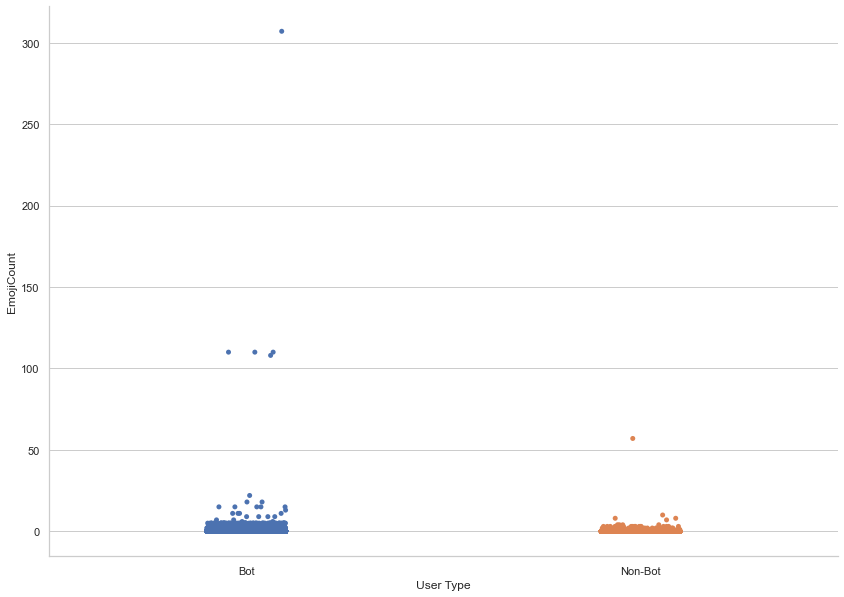

In [233]:
#Cat Plot of Emoji Count
sns.set(style="whitegrid")
sns.catplot(x="Class", y="EmojiCount", data=df, height=8.27, aspect=11.7/8.27, order=["Bot", "Non-Bot"])
plt.xlabel('User Type')

plt.show();

Bots appear to post emojis more frequently than non-bots.

#### iii. Clean Comment Text

In [234]:
#Replace special characters
df['CommentClean'] = df['Comment'].str.replace('[^a-zA-Z]', ' ')
df['CommentClean'] = df['Comment'].str.lower()

#Visual Check
df.tail(2)

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class,FlairCount,EmojiCount,CommentClean
39384,dgga1g2,janellemonae,❤️,pics,3,2017-04-18 19:49:01,None,Non-Bot,0,1,❤️
39385,ddur7h1,janellemonae,Trying to get him to get an account so he can ...,hiphopheads,253,2017-02-16 22:22:57,THE QUEEN,Non-Bot,1,0,trying to get him to get an account so he can ...


#### iv. Comment Length

In [235]:
df['CommentLength'] = df['CommentClean'].str.split().str.len()
df.tail(2)

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class,FlairCount,EmojiCount,CommentClean,CommentLength
39384,dgga1g2,janellemonae,❤️,pics,3,2017-04-18 19:49:01,None,Non-Bot,0,1,❤️,1
39385,ddur7h1,janellemonae,Trying to get him to get an account so he can ...,hiphopheads,253,2017-02-16 22:22:57,THE QUEEN,Non-Bot,1,0,trying to get him to get an account so he can ...,13


In [236]:
df['CommentLength'].describe()

count    39386.000000
mean        44.587290
std        101.257559
min          1.000000
25%          8.000000
50%         19.000000
75%         45.000000
max       2989.000000
Name: CommentLength, dtype: float64

#### v. Average Word Length

In [237]:
df['CommentCharacters'] = df['CommentClean'].str.len()
df['AvgWordLength'] = (df['CommentCharacters'] / df['CommentLength']).round(2)
df.head(2)

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class,FlairCount,EmojiCount,CommentClean,CommentLength,CommentCharacters,AvgWordLength
0,e7wig3e,ADHDbot,Just dropping by to show that OP is completely...,unpopularopinion,4,2018-10-16 16:47:28,None,Bot,0,0,just dropping by to show that op is completely...,21,335,15.95
1,cww687m,ADHDbot,"As per the rules in the side bar, yes or no qu...",ADHD,1,2015-11-10 20:03:58,None,Bot,0,0,"as per the rules in the side bar, yes or no qu...",105,823,7.84


In [238]:
df['AvgWordLength'].describe()

count    39386.000000
mean        11.483930
std         11.533438
min          1.000000
25%          5.570000
50%          7.620000
75%         13.000000
max        444.000000
Name: AvgWordLength, dtype: float64

In [239]:
#Check for Null Values
df['AvgWordLength'].isnull().sum()

0

In [240]:
#Convert infinite to NaN
df['AvgWordLength'].replace(-np.inf, np.nan, inplace=True)

In [241]:
#Replace NaN with Median
df['AvgWordLength'].fillna(df['AvgWordLength'].median(), inplace=True)

In [242]:
df['AvgWordLength'].describe()

count    39386.000000
mean        11.483930
std         11.533438
min          1.000000
25%          5.570000
50%          7.620000
75%         13.000000
max        444.000000
Name: AvgWordLength, dtype: float64

#### vi. Lexicon Count

Calculates the number of words present in the text. 

In [243]:
df["LexCount"] = df['CommentClean'].apply(textstat.lexicon_count)

df.head(1)

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class,FlairCount,EmojiCount,CommentClean,CommentLength,CommentCharacters,AvgWordLength,LexCount
0,e7wig3e,ADHDbot,Just dropping by to show that OP is completely...,unpopularopinion,4,2018-10-16 16:47:28,None,Bot,0,0,just dropping by to show that op is completely...,21,335,15.95,21


In [244]:
df["LexCount"].describe()

count    39386.000000
mean        42.875311
std         97.109138
min          0.000000
25%          8.000000
50%         19.000000
75%         44.000000
max       2987.000000
Name: LexCount, dtype: float64

#### vii. Sentence Count

In [245]:
df["SentenceCount"] = df['Comment'].apply(textstat.sentence_count)
df.tail(2)

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class,FlairCount,EmojiCount,CommentClean,CommentLength,CommentCharacters,AvgWordLength,LexCount,SentenceCount
39384,dgga1g2,janellemonae,❤️,pics,3,2017-04-18 19:49:01,None,Non-Bot,0,1,❤️,1,2,2.00,1,1
39385,ddur7h1,janellemonae,Trying to get him to get an account so he can ...,hiphopheads,253,2017-02-16 22:22:57,THE QUEEN,Non-Bot,1,0,trying to get him to get an account so he can ...,13,62,4.77,13,1


#### viii. Readability

In [246]:
df["ReadEase"] = df['CommentClean'].apply(textstat.flesch_reading_ease)

df.head(1)

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class,FlairCount,EmojiCount,CommentClean,CommentLength,CommentCharacters,AvgWordLength,LexCount,SentenceCount,ReadEase
0,e7wig3e,ADHDbot,Just dropping by to show that OP is completely...,unpopularopinion,4,2018-10-16 16:47:28,None,Bot,0,0,just dropping by to show that op is completely...,21,335,15.95,21,1,-59.83


In [247]:
df["ReadEase"].describe()

count    39386.000000
mean       -38.355350
std        202.666966
min      -5377.790000
25%        -68.960000
50%         13.280000
75%         68.770000
max        206.840000
Name: ReadEase, dtype: float64

#### ix. Syllable Count

In [248]:
df["SyllableCount"] = df['CommentClean'].apply(textstat.syllable_count)
df["SyllableCount"].describe()

count    39386.000000
mean        83.602067
std        173.207563
min          0.000000
25%         15.000000
50%         39.000000
75%         84.000000
max       4368.000000
Name: SyllableCount, dtype: float64

In [249]:
#Check for Null Values
df.isnull().sum()

ID                   0
Author               0
Comment              0
Subreddit            0
Score                0
Time                 0
Flair                0
Class                0
FlairCount           0
EmojiCount           0
CommentClean         0
CommentLength        0
CommentCharacters    0
AvgWordLength        0
LexCount             0
SentenceCount        0
ReadEase             0
SyllableCount        0
dtype: int64

### <a id='PP'>B. Pre-Processing and Scaling</a>

#### i. Create Dummy Variables

Creating dummy variables for: Class (Bot/Non-Bot)

In [250]:
#Create Dummies for Class
classDummies = pd.get_dummies(df.Class)

In [251]:
#Join Dummies
df2 = pd.concat([df, classDummies], axis=1)

#Visual Check
df2.head(2)

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class,FlairCount,EmojiCount,CommentClean,CommentLength,CommentCharacters,AvgWordLength,LexCount,SentenceCount,ReadEase,SyllableCount,Bot,Non-Bot
0,e7wig3e,ADHDbot,Just dropping by to show that OP is completely...,unpopularopinion,4,2018-10-16 16:47:28,None,Bot,0,0,just dropping by to show that op is completely...,21,335,15.95,21,1,-59.83,61,1,0
1,cww687m,ADHDbot,"As per the rules in the side bar, yes or no qu...",ADHD,1,2015-11-10 20:03:58,None,Bot,0,0,"as per the rules in the side bar, yes or no qu...",105,823,7.84,105,2,-52.03,191,1,0


In [252]:
df2.shape

(39386, 20)

#### ii. Drop Values to include equal number of Bots and Non-Bots in data set

In [253]:
(df2['Class'] == 'Bot').sum()

28962

In [254]:
(df2['Class'] == 'Non-Bot').sum()

10424

> I want an equal number of bots and non-bots, so I will remove 19,333 Bot rows from the data set

In [255]:
N = 18682
df3 = df2.drop(df2[df2['Class'] == 'Bot'].sample(N).index)

In [256]:
(df3['Class'] == 'Bot').sum()

10280

In [257]:
(df3['Class'] == 'Non-Bot').sum()

10424

In [258]:
df3.isna().sum()

ID                   0
Author               0
Comment              0
Subreddit            0
Score                0
Time                 0
Flair                0
Class                0
FlairCount           0
EmojiCount           0
CommentClean         0
CommentLength        0
CommentCharacters    0
AvgWordLength        0
LexCount             0
SentenceCount        0
ReadEase             0
SyllableCount        0
Bot                  0
Non-Bot              0
dtype: int64

#### iii. Split Features into Train and Test

In [259]:
features = []

for column in df3.columns:
    if column != 'Bot' and column != 'Non-Bot':
        features.append(column)
print(features)

['ID', 'Author', 'Comment', 'Subreddit', 'Score', 'Time', 'Flair', 'Class', 'FlairCount', 'EmojiCount', 'CommentClean', 'CommentLength', 'CommentCharacters', 'AvgWordLength', 'LexCount', 'SentenceCount', 'ReadEase', 'SyllableCount']


In [260]:
len(features)

18

In [261]:
X = df3[features]
y = df3['Bot']

In [262]:
#Split Features into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [263]:
X_train.shape

(16563, 18)

In [264]:
X_train = X_train.reset_index(drop = True)
X_train.head()

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class,FlairCount,EmojiCount,CommentClean,CommentLength,CommentCharacters,AvgWordLength,LexCount,SentenceCount,ReadEase,SyllableCount
0,gaa5btn,andrewsmith1986,I actually am not a huge fan of either of thei...,pics,1,2020-10-27 08:38:34,None,Non-Bot,0,0,i actually am not a huge fan of either of thei...,25,116,4.64,25,1,71.48,32
1,g928ygw,GovSchwarzenegger,Thank you for voting! Come back here and tell ...,ColumbusGA,1,2020-10-16 18:25:09,None,Non-Bot,0,0,thank you for voting! come back here and tell ...,13,61,4.69,13,2,100.58,14
2,ceqtp4u,snapshot_bot,The following URLs have been snapshotted:\n\n*...,new_eden_news_bot,1,2014-01-15 21:25:01,None,Bot,0,0,the following urls have been snapshotted:\n\n*...,19,302,15.89,16,1,-54.75,46
3,cdoceot,Chemistry_Bot,How about some more info on trisulfane:\n\nThe...,test,1,2013-11-27 10:56:18,None,Bot,0,0,how about some more info on trisulfane:\n\nthe...,38,275,7.24,36,2,26.48,60
4,cfkv060,randnumbot,Random integer between 1 and 55 is 30.,reddcoinlotto,2,2014-02-20 23:17:50,None,Bot,0,0,random integer between 1 and 55 is 30.,8,38,4.75,8,1,71.82,12


In [265]:
X_test = X_test.reset_index(drop = True)
X_test.head()

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class,FlairCount,EmojiCount,CommentClean,CommentLength,CommentCharacters,AvgWordLength,LexCount,SentenceCount,ReadEase,SyllableCount
0,cg1tmg1,redditreviewbot,Buck up! You can do it.,Random_Acts_Of_Amazon,2,2014-03-13 12:35:02,None,Bot,0,0,buck up! you can do it.,6,23,3.83,6,1,116.15,6
1,dgiw905,Here_Comes_The_King,what can celebs do to use their voice to suppo...,trees,421,2017-04-20 10:48:32,None,Non-Bot,0,0,what can celebs do to use their voice to suppo...,11,64,5.82,11,1,68.77,16
2,g86vapp,unibeech,Technically wasn't legal proceedings. I had ap...,Parenting,1,2020-10-08 22:27:28,None,Non-Bot,0,0,technically wasn't legal proceedings. i had ap...,253,1407,5.56,253,8,-168.41,350
3,ga2xwx7,garlicdeath,I had to laugh cause I heard about this on NPR...,worldnews,1,2020-10-25 11:18:36,None,Non-Bot,0,0,i had to laugh cause i heard about this on npr...,36,178,4.94,36,1,68.78,43
4,cjqifma,SakuraiBot_test,Full text: \n&gt;Long Picture test: 94af315c-...,SakuraiBot_test,1,2014-08-14 16:14:07,None,Bot,0,0,full text: \n&gt;long picture test: 94af315c-...,70,490,7.00,68,2,27.84,87


#### iv. Create TFIDF vectors

In [266]:
#Transform Training Data to Tfidf vectors
cv = CountVectorizer(stop_words='english', max_features=1000, ngram_range=(2,2))
X_train_counts = cv.fit_transform(X_train['CommentClean'])

tf = TfidfTransformer(use_idf=False)
X_train_tfidf = tf.fit_transform(X_train_counts)

print (X_train_tfidf.shape)

(16563, 1000)


In [267]:
# Create a DataFrame of the features for X_train
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), 
                 columns=cv.get_feature_names()).add_prefix('Counts_')

In [268]:
X_train_tfidf_df.head()

,Counts_0000 0000,Counts_000000 fedoracoin,Counts_009 amp,Counts_0a 0a,Counts_0a 0aplease,Counts_10 15,Counts_10 bonus,Counts_100 bonus,Counts_12 hour,Counts_1339 cf,...,Counts_xl torpedo,Counts_year old,Counts_years ago,Counts_years old,Counts_yes yes,Counts_youtube com,Counts_youtube mirror,Counts_yugioh prices,Counts_yugioh wikia,Counts_zh reddit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [269]:
X_train_tfidf_df.shape

(16563, 1000)

In [270]:
#Join X_train with TFIDF features
X_train = X_train.join(X_train_tfidf_df)

In [271]:
X_train.head(2)

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class,FlairCount,EmojiCount,...,Counts_xl torpedo,Counts_year old,Counts_years ago,Counts_years old,Counts_yes yes,Counts_youtube com,Counts_youtube mirror,Counts_yugioh prices,Counts_yugioh wikia,Counts_zh reddit
0,gaa5btn,andrewsmith1986,I actually am not a huge fan of either of thei...,pics,1,2020-10-27 08:38:34,None,Non-Bot,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,g928ygw,GovSchwarzenegger,Thank you for voting! Come back here and tell ...,ColumbusGA,1,2020-10-16 18:25:09,None,Non-Bot,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [272]:
X_train.shape

(16563, 1018)

In [273]:
#Transform Test Data to Tfidf vectors
X_test_counts = cv.transform(X_test['CommentClean'])

tf = TfidfTransformer(use_idf=False)
X_test_tfidf = tf.transform(X_test_counts)

print (X_test_tfidf.shape)

(4141, 1000)


In [274]:
# Create a DataFrame of the features for X_test
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), 
                 columns=cv.get_feature_names()).add_prefix('Counts_')

X_test_tfidf_df.head()

,Counts_0000 0000,Counts_000000 fedoracoin,Counts_009 amp,Counts_0a 0a,Counts_0a 0aplease,Counts_10 15,Counts_10 bonus,Counts_100 bonus,Counts_12 hour,Counts_1339 cf,...,Counts_xl torpedo,Counts_year old,Counts_years ago,Counts_years old,Counts_yes yes,Counts_youtube com,Counts_youtube mirror,Counts_yugioh prices,Counts_yugioh wikia,Counts_zh reddit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [275]:
#Join X_test with TFIDF features
X_test = X_test.join(X_test_tfidf_df)

X_test.head(2)

,ID,Author,Comment,Subreddit,Score,Time,Flair,Class,FlairCount,EmojiCount,...,Counts_xl torpedo,Counts_year old,Counts_years ago,Counts_years old,Counts_yes yes,Counts_youtube com,Counts_youtube mirror,Counts_yugioh prices,Counts_yugioh wikia,Counts_zh reddit
0,cg1tmg1,redditreviewbot,Buck up! You can do it.,Random_Acts_Of_Amazon,2,2014-03-13 12:35:02,None,Bot,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dgiw905,Here_Comes_The_King,what can celebs do to use their voice to suppo...,trees,421,2017-04-20 10:48:32,None,Non-Bot,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [276]:
X_test.shape

(4141, 1018)

In [277]:
#Drop Categorical/Text Features
X_train = X_train.drop(['ID', 'Author', 'Comment', 'Subreddit', 'Time', 'Flair', 'Class', 'CommentClean'], axis=1)

#Visual Check
X_train.head(2)

,Score,FlairCount,EmojiCount,CommentLength,CommentCharacters,AvgWordLength,LexCount,SentenceCount,ReadEase,SyllableCount,...,Counts_xl torpedo,Counts_year old,Counts_years ago,Counts_years old,Counts_yes yes,Counts_youtube com,Counts_youtube mirror,Counts_yugioh prices,Counts_yugioh wikia,Counts_zh reddit
0,1,0,0,25,116,4.64,25,1,71.48,32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,13,61,4.69,13,2,100.58,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [278]:
X_train.shape

(16563, 1010)

In [279]:
#Drop Categorical/Text Features
X_test = X_test.drop(['ID', 'Author', 'Comment', 'Subreddit', 'Time', 'Flair', 'Class','CommentClean'], axis=1)

#Visual Check
X_test.head(2)

,Score,FlairCount,EmojiCount,CommentLength,CommentCharacters,AvgWordLength,LexCount,SentenceCount,ReadEase,SyllableCount,...,Counts_xl torpedo,Counts_year old,Counts_years ago,Counts_years old,Counts_yes yes,Counts_youtube com,Counts_youtube mirror,Counts_yugioh prices,Counts_yugioh wikia,Counts_zh reddit
0,2,0,0,6,23,3.83,6,1,116.15,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,421,0,0,11,64,5.82,11,1,68.77,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [280]:
X_test.shape

(4141, 1010)

#### v. Scale Train and Test Sets

In [281]:
#Instantiate MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

#Fit and Transform X_train
mm_scaler.fit_transform(X_train)

#Transform X_test
mm_scaler.transform(X_test)

array([[0.03333829, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04578814, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03330857, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03327886, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03330857, 0.25      , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03330857, 0.25      , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### <a id='FM'>D. Fit Models</a>

#### i. Logistic Regression

In [282]:
clf = LogisticRegression(max_iter=1000)

# Fit the model on the training data.
clf.fit(X_train, y_train)

# Print the accuracy from the testing data.
y_pred = clf.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.85


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


#### ii. Gradient Boosting Classifier

In [283]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate = .25, max_features=1000, max_depth = 10, random_state = 0, min_samples_split=50)
gb.fit(X_train, y_train)
print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
print()


Accuracy score (training): 0.936
Accuracy score (validation): 0.900



### <a id='SD'>D. Save Data and Models</a>

#### i. Data

In [295]:
X_train.to_csv('Data/X_train.csv', index=False)

In [296]:
X_test.to_csv('Data/X_test.csv', index=False)

In [297]:
y_train.to_csv('Data/y_train.csv', index=False)

In [298]:
y_test.to_csv('Data/y_test.csv', index=False)

#### ii. Count Vectorizer and TfidfTransformer

In [288]:
#Save Count Vectorizer
cv_pickle = 'Models/cv.pkl'
pickle.dump(cv, open(cv_pickle, 'wb'))

In [289]:
#Save TfidfTransformer
tf_pickle = 'Models/tf.pkl'
pickle.dump(tf, open(tf_pickle, 'wb'))

#### iii. Scaler

In [290]:
mm_pickle = 'Models/scaler.pkl'
pickle.dump(mm_scaler, open(mm_pickle, 'wb'))

#### iv. Models

In [291]:
#Save Logistic Regression Model
lr_pickle = 'Models/Logistic_Regression_Model.pkl'
pickle.dump(clf, open(lr_pickle, 'wb'))

In [292]:
# Check Model
loaded_model = pickle.load(open(lr_pickle, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.850277710697899


In [293]:
#Save Gradient Boosting Model
gb_pickle = 'Models/Gradient_Boosting_Model.pkl'
pickle.dump(gb, open(gb_pickle, 'wb'))

In [294]:
# Check Model
loaded_model = pickle.load(open(gb_pickle, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8997826611929486
